In [52]:
import numpy as np
from glob import glob
import os
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import seaborn as sns
import logging

from src.utils.ConfigData import ConfigAnalysis, ConfigData

logging.basicConfig(level=logging.ERROR)

In [4]:
config_analysis_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/configs/config_analysis.json"
config_analysis = ConfigAnalysis.from_json(config_analysis_path)

config_data_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/configs/config_data.json"
config_data = ConfigData.from_json(config_data_path)

zs_list = config_data.zs_list
sl_list = config_analysis.sl_arcmin

In [8]:
sigmas = np.load(os.path.join(config_analysis.resultsdir, "sigmas_original.npy"))
print(sigmas)

[[0.00880932 0.00881507]
 [0.01850036 0.01854369]
 [0.02692484 0.02698387]
 [0.03377026 0.03384087]]


In [40]:
sigmas_smoothed = dict(np.load(os.path.join(config_analysis.resultsdir, "sigmas_smoothed.npy"), allow_pickle=True).tolist())

In [41]:
sigmas_smoothed

{0.5: {5: (0.0038850096, 0.0038753804),
  8: (0.0032226068, 0.0032132622),
  10: (0.0029421293, 0.0029334037)},
 1.0: {5: (0.0073408866, 0.0073610977),
  8: (0.0060957386, 0.006112142),
  10: (0.005566794, 0.005582724)},
 1.5: {5: (0, 0), 8: (0, 0), 10: (0, 0)},
 2.0: {5: (0.012337493, 0.0123800635),
  8: (0.010239631, 0.010279812),
  10: (0.00932129, 0.009360254)}}

In [11]:
lmin, lmax, nbin = 300, 3000, 15

l_edges = np.linspace(lmin, lmax, nbin, endpoint=True)
kappa_bins_tiled = [np.linspace(-4, 4, nbin, endpoint=True) * sigmas[i, 0] for i in range(len(zs_list))]
kappa_bins_bigbox = [np.linspace(-4, 4, nbin, endpoint=True) * sigmas[i, 1] for i in range(len(zs_list))]

# Data Loading

## Power Spectrum

In [42]:
def compute_correlation(kappa_map_files, sigma):
    clkks = [np.load(f)['clkk']/sigma**2 for f in kappa_map_files]
    ell = np.load(kappa_map_files[0])['ell']
    clkks = np.array(clkks)

    cov_clkk = np.cov(clkks, rowvar=False)

    diagonal_terms = np.diag(cov_clkk)
    correlation = cov_clkk / np.sqrt(diagonal_terms[:, None] * diagonal_terms[None, :])

    return ell, clkks, cov_clkk, correlation, diagonal_terms

In [19]:
path_clkk_tiled = [glob(os.path.join(config_analysis.resultsdir, "tiled", "Clkk", "patch_flat", f"zs{z:.1f}", f"*_{lmin}_{lmax}.npz")) for z in zs_list]
path_clkk_bigbox = [glob(os.path.join(config_analysis.resultsdir, "bigbox", "Clkk", "patch_flat", f"zs{z:.1f}", f"*_{lmin}_{lmax}.npz")) for z in zs_list]

In [43]:
data_clkk_tiled = [compute_correlation(p, sigmas[i][0]) for i, p in enumerate(path_clkk_tiled)]
data_clkk_bigbox = [compute_correlation(p, sigmas[i][1]) for i, p in enumerate(path_clkk_bigbox)]

In [54]:
mean_clkk_tiled, std_clkk_tiled = np.mean([d[1] for d in data_clkk_tiled], axis=0), np.std([d[1] for d in data_clkk_tiled], axis=0)
mean_clkk_bigbox, std_clkk_bigbox = np.mean([d[1] for d in data_clkk_bigbox], axis=0), np.std([d[1] for d in data_clkk_bigbox], axis=0)

## Bispectrum

In [44]:
def compute_correlation_bispectra(kappa_map_files, sigma):
    equilateral, halfed, squeezed = [], [], []
    for f in kappa_map_files:
        data = np.load(f)
        equilateral.append(data['equilateral']/sigma**3)
        halfed.append(data['halfed']/sigma**3)
        squeezed.append(data['squeezed']/sigma**3)
        if 'ell' not in locals(): 
            ell = data['ell']

    equilateral = np.array(equilateral)
    halfed = np.array(halfed)
    squeezed = np.array(squeezed)

    cov_equilateral = np.cov(equilateral, rowvar=False)
    cov_halfed = np.cov(halfed, rowvar=False)
    cov_squeezed = np.cov(squeezed, rowvar=False)

    diagonal_equilateral = np.diag(cov_equilateral)
    diagonal_halfed = np.diag(cov_halfed)
    diagonal_squeezed = np.diag(cov_squeezed)

    correlation_equilateral = cov_equilateral / np.sqrt(diagonal_equilateral[:, None] * diagonal_equilateral[None, :])
    correlation_halfed = cov_halfed / np.sqrt(diagonal_halfed[:, None] * diagonal_halfed[None, :])
    correlation_squeezed = cov_squeezed / np.sqrt(diagonal_squeezed[:, None] * diagonal_squeezed[None, :])

    return ell, equilateral, halfed, squeezed, cov_equilateral, cov_halfed, cov_squeezed, correlation_equilateral, correlation_halfed, correlation_squeezed, diagonal_equilateral, diagonal_halfed, diagonal_squeezed

In [48]:
path_bispec_tiled = [glob(os.path.join(config_analysis.resultsdir, "tiled", "Bispectrum", "patch_flat", f"zs{z:.1f}", f"*_{lmin}_{lmax}.npz")) for z in zs_list]
path_bispec_bigbox = [glob(os.path.join(config_analysis.resultsdir, "bigbox", "Bispectrum", "patch_flat", f"zs{z:.1f}", f"*_{lmin}_{lmax}.npz")) for z in zs_list]

In [45]:
data_bispec_tiled = np.array([compute_correlation_bispectra(p, sigmas[i][0]) for i, p in enumerate(path_bispec_tiled)])
data_bispec_bigbox = np.array([compute_correlation_bispectra(p, sigmas[i][1]) for i, p in enumerate(path_bispec_bigbox)])

/var/tmp/pbs.267385.idark/ipykernel_54323/1903092718.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_bispec_tiled = np.array([compute_correlation_bispectra(p, sigmas[i][0]) for i, p in enumerate(path_bispec_tiled)])
/var/tmp/pbs.267385.idark/ipykernel_54323/1903092718.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_bispec_bigbox = np.array([compute_correlation_bispectra(p, sigmas[i][1]) for i, p in enumerate(path_bispec_bigbox)])


In [46]:
indices_equilateral = np.array([0, 1, 4, 7, 10])
indices_halfed = np.array([0, 2, 5, 8, 11])
indices_squeezed = np.array([0, 3, 6, 9, 12])


data_bispec_tiled_equilateral = [d[indices_equilateral] for d in data_bispec_tiled]
data_bispec_tiled_halfed = [d[indices_halfed] for d in data_bispec_tiled]
data_bispec_tiled_squeezed = [d[indices_squeezed] for d in data_bispec_tiled]

data_bispec_bigbox_equilateral = [d[indices_equilateral] for d in data_bispec_bigbox]
data_bispec_bigbox_halfed = [d[indices_halfed] for d in data_bispec_bigbox]
data_bispec_bigbox_squeezed = [d[indices_squeezed] for d in data_bispec_bigbox]

In [55]:
mean_equilateral_tiled, std_equilateral_tiled = np.mean([d[1] for d in data_bispec_tiled_equilateral], axis=0), np.std([d[1] for d in data_bispec_tiled_equilateral], axis=0)
mean_halfed_tiled, std_halfed_tiled = np.mean([d[1] for d in data_bispec_tiled_halfed], axis=0), np.std([d[1] for d in data_bispec_tiled_halfed], axis=0)
mean_squeezed_tiled, std_squeezed_tiled = np.mean([d[1] for d in data_bispec_tiled_squeezed], axis=0), np.std([d[1] for d in data_bispec_tiled_squeezed], axis=0)

mean_equilateral_bigbox, std_equilateral_bigbox = np.mean([d[1] for d in data_bispec_bigbox_equilateral], axis=0), np.std([d[1] for d in data_bispec_bigbox_equilateral], axis=0)
mean_halfed_bigbox, std_halfed_bigbox = np.mean([d[1] for d in data_bispec_bigbox_halfed], axis=0), np.std([d[1] for d in data_bispec_bigbox_halfed], axis=0)
mean_squeezed_bigbox, std_squeezed_bigbox = np.mean([d[1] for d in data_bispec_bigbox_squeezed], axis=0), np.std([d[1] for d in data_bispec_bigbox_squeezed], axis=0)

## PDF

In [50]:
def compute_correlation_pdf(kappa_map_files):
    pdf = [np.load(f)['p'] for f in kappa_map_files]
    nu = np.load(kappa_map_files[0])['nu']
    pdf = np.array(pdf)

    cov_pdf = np.cov(pdf, rowvar=False)

    diagonal_terms = np.diag(cov_pdf)
    correlation = cov_pdf / np.sqrt(diagonal_terms[:, None] * diagonal_terms[None, :])

    return nu, pdf, cov_pdf, correlation, diagonal_terms

In [49]:
path_pdf_tiled = [glob(os.path.join(config_analysis.resultsdir, "tiled", "PDF", "patch_flat", f"zs{z:.1f}", f"*_pdf.npz")) for z in zs_list]
path_pdf_bigbox = [glob(os.path.join(config_analysis.resultsdir, "bigbox", "PDF", "patch_flat", f"zs{z:.1f}", f"*_pdf.npz")) for z in zs_list]

In [51]:
data_pdf_tiled = [compute_correlation_pdf(p) for p in path_pdf_tiled]
data_pdf_bigbox = [compute_correlation_pdf(p) for p in path_pdf_bigbox]

/var/tmp/pbs.267385.idark/ipykernel_54323/3396391134.py:9: RuntimeWarning: invalid value encountered in true_divide
  correlation = cov_pdf / np.sqrt(diagonal_terms[:, None] * diagonal_terms[None, :])


In [56]:
mean_pdf_tiled, std_pdf_tiled = np.mean([d[1] for d in data_pdf_tiled], axis=0), np.std([d[1] for d in data_pdf_tiled], axis=0)
mean_pdf_bigbox, std_pdf_bigbox = np.mean([d[1] for d in data_pdf_bigbox], axis=0), np.std([d[1] for d in data_pdf_bigbox], axis=0)

In [66]:
mean_pdf_tiled

array([[3.21537709e-01, 5.80764395e-01, 1.12751508e+00, ...,
        1.88815822e-03, 0.00000000e+00, 0.00000000e+00],
       [3.72408743e-01, 6.78665186e-01, 1.26184680e+00, ...,
        2.05813525e-03, 0.00000000e+00, 0.00000000e+00],
       [4.12235360e-01, 7.44755240e-01, 1.38387184e+00, ...,
        1.70196198e-03, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.84876441e-01, 7.14639323e-01, 1.35253054e+00, ...,
        1.12241386e-03, 0.00000000e+00, 0.00000000e+00],
       [3.38509801e-01, 6.21389713e-01, 1.19827720e+00, ...,
        1.34280921e-03, 0.00000000e+00, 0.00000000e+00],
       [4.44530212e-01, 7.92934824e-01, 1.50331795e+00, ...,
        1.66907122e-03, 0.00000000e+00, 0.00000000e+00]])

## Full covariance

In [133]:
data_full_tiled = np.array([np.hstack([data_clkk_tiled[i][1], data_bispec_tiled_equilateral[i][1], 
                                  data_bispec_tiled_halfed[i][1], data_bispec_tiled_squeezed[i][1], 
                                  data_pdf_tiled[i][1]]) for i in range(len(zs_list))])
data_full_bigbox = np.array([np.hstack([data_clkk_bigbox[i][1], data_bispec_bigbox_equilateral[i][1],
                                      data_bispec_bigbox_halfed[i][1], data_bispec_bigbox_squeezed[i][1],
                                      data_pdf_bigbox[i][1]]) for i in range(len(zs_list))])

cov_full_tiled = np.array([np.cov(data_full_tiled[i], rowvar=False) for i in range(len(zs_list))])
cov_full_bigbox = np.array([np.cov(data_full_bigbox[i], rowvar=False) for i in range(len(zs_list))])

In [137]:
correlation_full_tiled = np.array([cov_full_tiled[i] / np.sqrt(np.diag(cov_full_tiled[i])[:, None] * np.diag(cov_full_tiled[i])[None, :]) for i in range(len(zs_list))])
correlation_full_bigbox = np.array([cov_full_bigbox[i] / np.sqrt(np.diag(cov_full_bigbox[i])[:, None] * np.diag(cov_full_bigbox[i])[None, :]) for i in range(len(zs_list))])

/var/tmp/pbs.267385.idark/ipykernel_54323/1899600288.py:1: RuntimeWarning: invalid value encountered in true_divide
  correlation_full_tiled = np.array([cov_full_tiled[i] / np.sqrt(np.diag(cov_full_tiled[i])[:, None] * np.diag(cov_full_tiled[i])[None, :]) for i in range(len(zs_list))])
/var/tmp/pbs.267385.idark/ipykernel_54323/1899600288.py:2: RuntimeWarning: invalid value encountered in true_divide
  correlation_full_bigbox = np.array([cov_full_bigbox[i] / np.sqrt(np.diag(cov_full_bigbox[i])[:, None] * np.diag(cov_full_bigbox[i])[None, :]) for i in range(len(zs_list))])


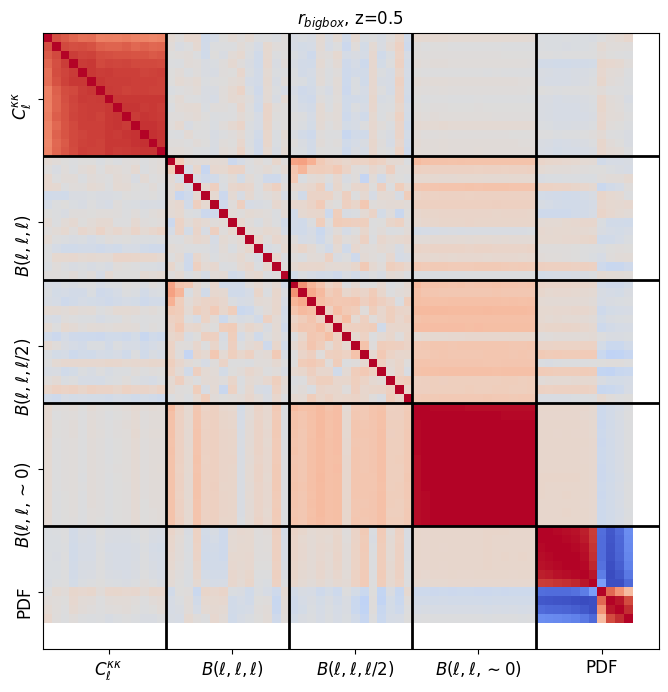

In [176]:
from matplotlib.colors import LogNorm

# Compute the matrix to plot
matrix = correlation_full_bigbox[0] 

# Define the labels for each statistics block
labels = [r'$C^{\kappa\kappa}_{\ell}$', r'$B(\ell, \ell, \ell)$', r'$B(\ell, \ell, \ell/2)$', r'$B(\ell, \ell, \sim0)$', 'PDF']

# Create the plot
plt.figure(figsize=(8, 8))
plt.imshow(matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Add labels and title
plt.title(r"$r_{bigbox}$"+f", z={zs_list[0]}", fontsize=12)

# Define tick positions and labels
tick_positions = [7 + 14 * i for i in range(5)]  # Center positions of each 14x14 block

plt.xticks(tick_positions, labels, fontsize=12)
plt.yticks(tick_positions, labels, fontsize=12, rotation=90, ha='right')

# Add grid lines to separate statistics
num_blocks = 70 // 14  # There are 5 blocks
for i in range(1, num_blocks):
    plt.axhline(y=i * 14 - 0.5, color='black', linewidth=2)
    plt.axvline(x=i * 14 - 0.5, color='black', linewidth=2)

# Show the plot
plt.show()

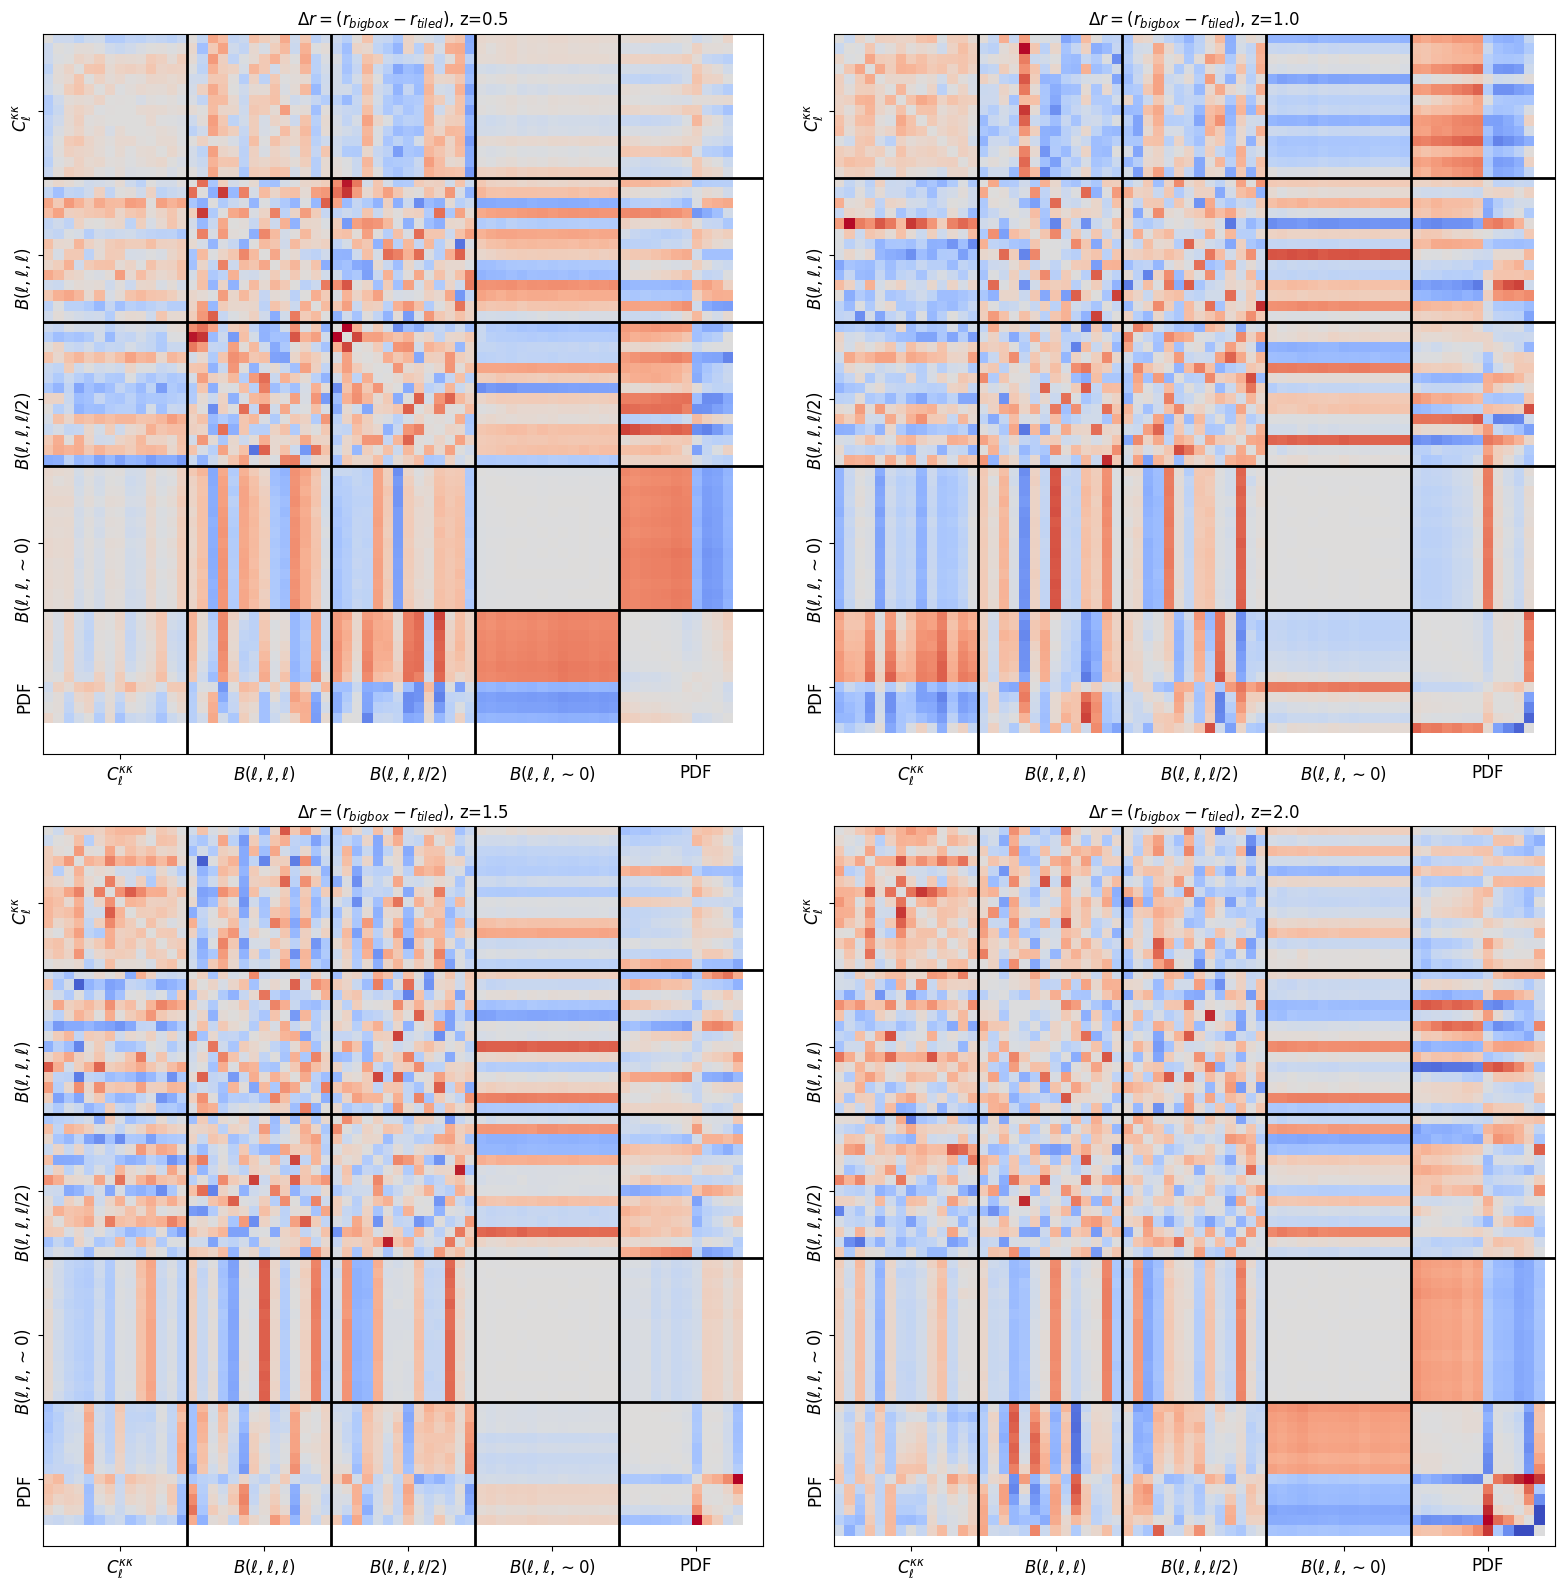

In [184]:
# Define the labels for each statistics block
labels = [r'$C^{\kappa\kappa}_{\ell}$', r'$B(\ell, \ell, \ell)$', r'$B(\ell, \ell, \ell/2)$', r'$B(\ell, \ell, \sim0)$', 'PDF']

# Create the plot
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

for idx, ax in enumerate(axes.flat):
    matrix = correlation_full_bigbox[idx] - correlation_full_tiled[idx]

    im = ax.imshow(matrix, cmap='coolwarm', vmin=-0.3, vmax=0.3)

    tick_positions = [7 + 14 * i for i in range(5)]  # Center positions of each 14x14 block

    ax.set_title(r"$\Delta r = (r_{bigbox} - r_{tiled})$"+f", z={zs_list[idx]}", fontsize=12)

    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels(labels, fontsize=12, rotation=90, ha='right')


    # Add grid lines to separate statistics
    num_blocks = 70 // 14  # There are 5 blocks
    for i in range(1, num_blocks):
        ax.axhline(y=i * 14 - 0.5, color='black', linewidth=2)
        ax.axvline(x=i * 14 - 0.5, color='black', linewidth=2)

# Show the plot
plt.tight_layout()
plt.show()

## Plot smoothingless data

/var/tmp/pbs.267385.idark/ipykernel_54323/1067799364.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


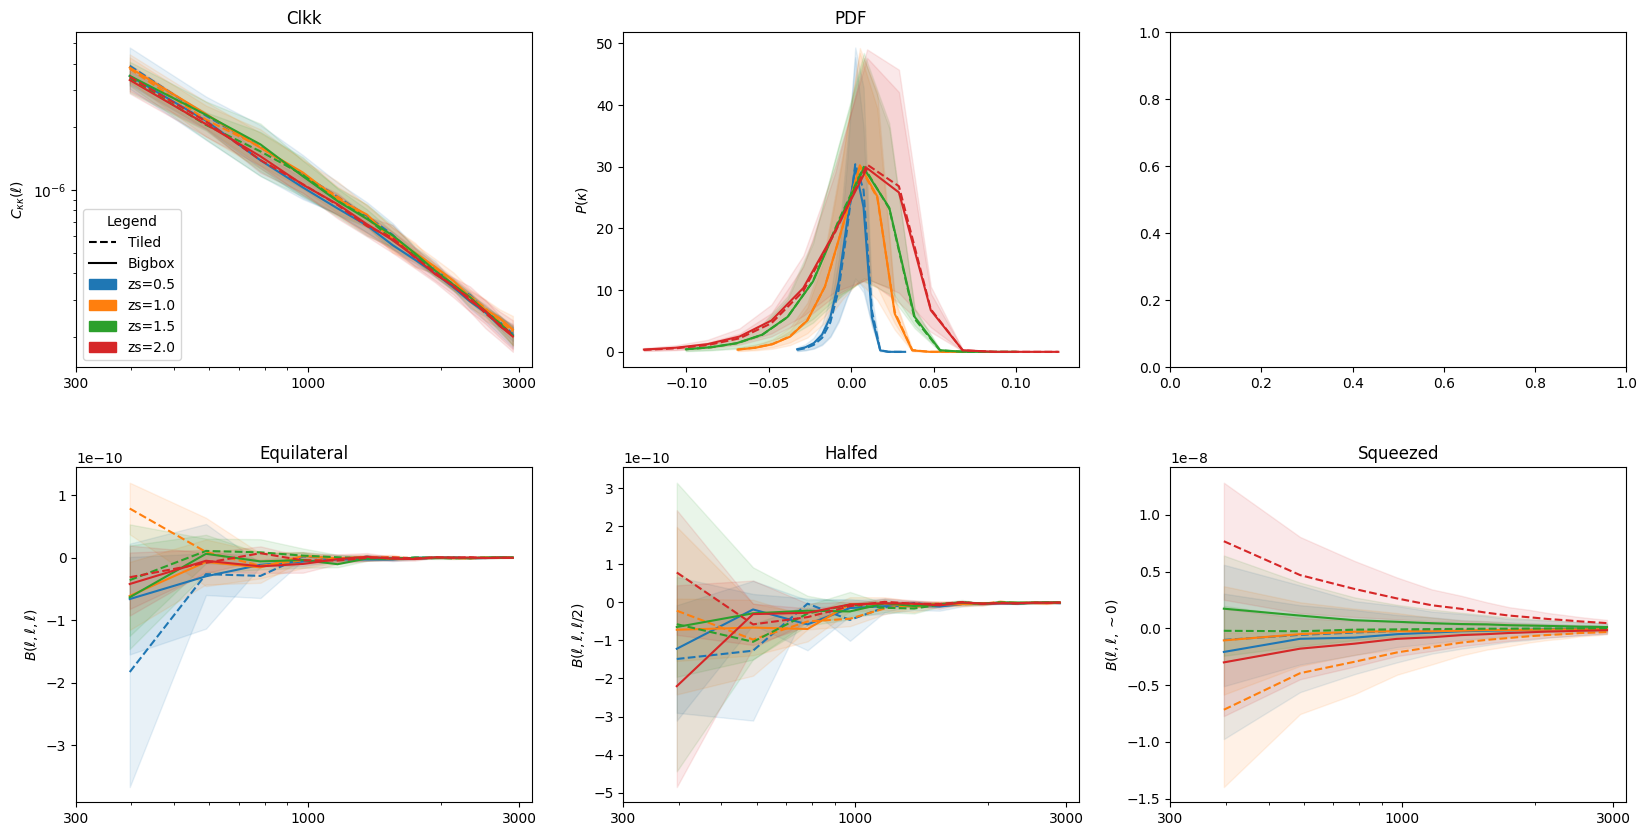

In [179]:
# Define colormap
cmap = plt.get_cmap("tab10")
colors = {zs: cmap(i) for i, zs in enumerate(zs_list)}

# Define line styles
line_styles = {"tiled": "--", "bigbox": "-"}

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 3, hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)] + [fig.add_subplot(gs[1, i]) for i in range(3)]

for i, zs in enumerate(zs_list):
    # Plot the mean Clkk, Bispectrum and PDF with 1-sigma shaded region
    axes[0].plot(data_clkk_tiled[i][0], mean_clkk_tiled[i], color=colors[zs], label=f"tiled", linestyle=line_styles["tiled"])
    axes[0].fill_between(data_clkk_tiled[i][0], mean_clkk_tiled[i] - std_clkk_tiled[i], mean_clkk_tiled[i] + std_clkk_tiled[i], color=colors[zs], alpha=0.1)
    axes[0].plot(data_clkk_bigbox[i][0], mean_clkk_bigbox[i], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])
    axes[0].fill_between(data_clkk_bigbox[i][0], mean_clkk_bigbox[i] - std_clkk_bigbox[i], mean_clkk_bigbox[i] + std_clkk_bigbox[i], color=colors[zs], alpha=0.1)

    axes[1].plot(data_pdf_tiled[i][0], mean_pdf_tiled[i], color=colors[zs], label=f"tiled", linestyle=line_styles["tiled"])
    axes[1].fill_between(data_pdf_tiled[i][0], mean_pdf_tiled[i] - std_pdf_tiled[i], mean_pdf_tiled[i] + std_pdf_tiled[i], color=colors[zs], alpha=0.1)
    axes[1].plot(data_pdf_bigbox[i][0], mean_pdf_bigbox[i], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])
    axes[1].fill_between(data_pdf_bigbox[i][0], mean_pdf_bigbox[i] - std_pdf_bigbox[i], mean_pdf_bigbox[i] + std_pdf_bigbox[i], color=colors[zs], alpha=0.1)

    axes[3].plot(data_bispec_tiled_equilateral[i][0], mean_equilateral_tiled[i], color=colors[zs], label=f"tiled", linestyle=line_styles["tiled"])
    axes[3].fill_between(data_bispec_tiled_equilateral[i][0], mean_equilateral_tiled[i] - std_equilateral_tiled[i], mean_equilateral_tiled[i] + std_equilateral_tiled[i], color=colors[zs], alpha=0.1)
    axes[3].plot(data_bispec_bigbox_equilateral[i][0], mean_equilateral_bigbox[i], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])
    axes[3].fill_between(data_bispec_bigbox_equilateral[i][0], mean_equilateral_bigbox[i] - std_equilateral_bigbox[i], mean_equilateral_bigbox[i] + std_equilateral_bigbox[i], color=colors[zs], alpha=0.1)

    axes[4].plot(data_bispec_tiled_halfed[i][0], mean_halfed_tiled[i], color=colors[zs], label=f"tiled", linestyle=line_styles["tiled"])
    axes[4].fill_between(data_bispec_tiled_halfed[i][0], mean_halfed_tiled[i] - std_halfed_tiled[i], mean_halfed_tiled[i] + std_halfed_tiled[i], color=colors[zs], alpha=0.1)
    axes[4].plot(data_bispec_bigbox_halfed[i][0], mean_halfed_bigbox[i], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])
    axes[4].fill_between(data_bispec_bigbox_halfed[i][0], mean_halfed_bigbox[i] - std_halfed_bigbox[i], mean_halfed_bigbox[i] + std_halfed_bigbox[i], color=colors[zs], alpha=0.1)

    axes[5].plot(data_bispec_tiled_squeezed[i][0], mean_squeezed_tiled[i], color=colors[zs], label=f"tiled", linestyle=line_styles["tiled"])
    axes[5].fill_between(data_bispec_tiled_squeezed[i][0], mean_squeezed_tiled[i] - std_squeezed_tiled[i], mean_squeezed_tiled[i] + std_squeezed_tiled[i], color=colors[zs], alpha=0.1)
    axes[5].plot(data_bispec_bigbox_squeezed[i][0], mean_squeezed_bigbox[i], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])
    axes[5].fill_between(data_bispec_bigbox_squeezed[i][0], mean_squeezed_bigbox[i] - std_squeezed_bigbox[i], mean_squeezed_bigbox[i] + std_squeezed_bigbox[i], color=colors[zs], alpha=0.1)


# Set the axis labels
axes[0].set_ylabel(r"$C_{\kappa\kappa}(\ell)$")
axes[1].set_ylabel(r"$P(\kappa)$")
axes[3].set_ylabel(r"$B(\ell, \ell, \ell)$")
axes[4].set_ylabel(r"$B(\ell, \ell, \ell/2)$")
axes[5].set_ylabel(r"$B(\ell, \ell, \sim 0)$")

# Set the axis ticks
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xticks([300, 1000, 3000])
axes[0].get_xaxis().set_major_formatter(plt.ScalarFormatter())
axes[0].get_xaxis().set_minor_formatter(plt.NullFormatter())


for ax in axes[3:]:
    ax.set_xscale("log")
    ax.set_xticks([300, 1000, 3000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.get_xaxis().set_minor_formatter(plt.NullFormatter())


# Custom legend handles
legend_handles = []

# Add handles for line styles
legend_handles.append(Line2D([0], [0], color='black', linestyle=line_styles["tiled"], label='Tiled'))
legend_handles.append(Line2D([0], [0], color='black', linestyle=line_styles["bigbox"], label='Bigbox'))

# Add handles for colors (redshifts)
for zs in zs_list:
    legend_handles.append(Patch(color=colors[zs], label=f"zs={zs}"))

# Place the legend in the first subplot
axes[0].legend(handles=legend_handles, title="Legend", loc='lower left')

# Set the title
axes[0].set_title("Clkk")
axes[1].set_title("PDF")
axes[3].set_title("Equilateral")
axes[4].set_title("Halfed")
axes[5].set_title("Squeezed")

# Save the figure
#plt.savefig(os.path.join(config_analysis.resultsdir, "correlation.pdf"), bbox_inches="tight")

plt.tight_layout()
plt.show()

## Plot Diagonal

/var/tmp/pbs.267385.idark/ipykernel_54323/669036874.py:33: RuntimeWarning: invalid value encountered in true_divide
  ratio_axes[1].plot(data_pdf_tiled[i][0], data_pdf_bigbox[i][4]/data_pdf_tiled[i][4], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])
/var/tmp/pbs.267385.idark/ipykernel_54323/669036874.py:33: RuntimeWarning: divide by zero encountered in true_divide
  ratio_axes[1].plot(data_pdf_tiled[i][0], data_pdf_bigbox[i][4]/data_pdf_tiled[i][4], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])
/var/tmp/pbs.267385.idark/ipykernel_54323/669036874.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


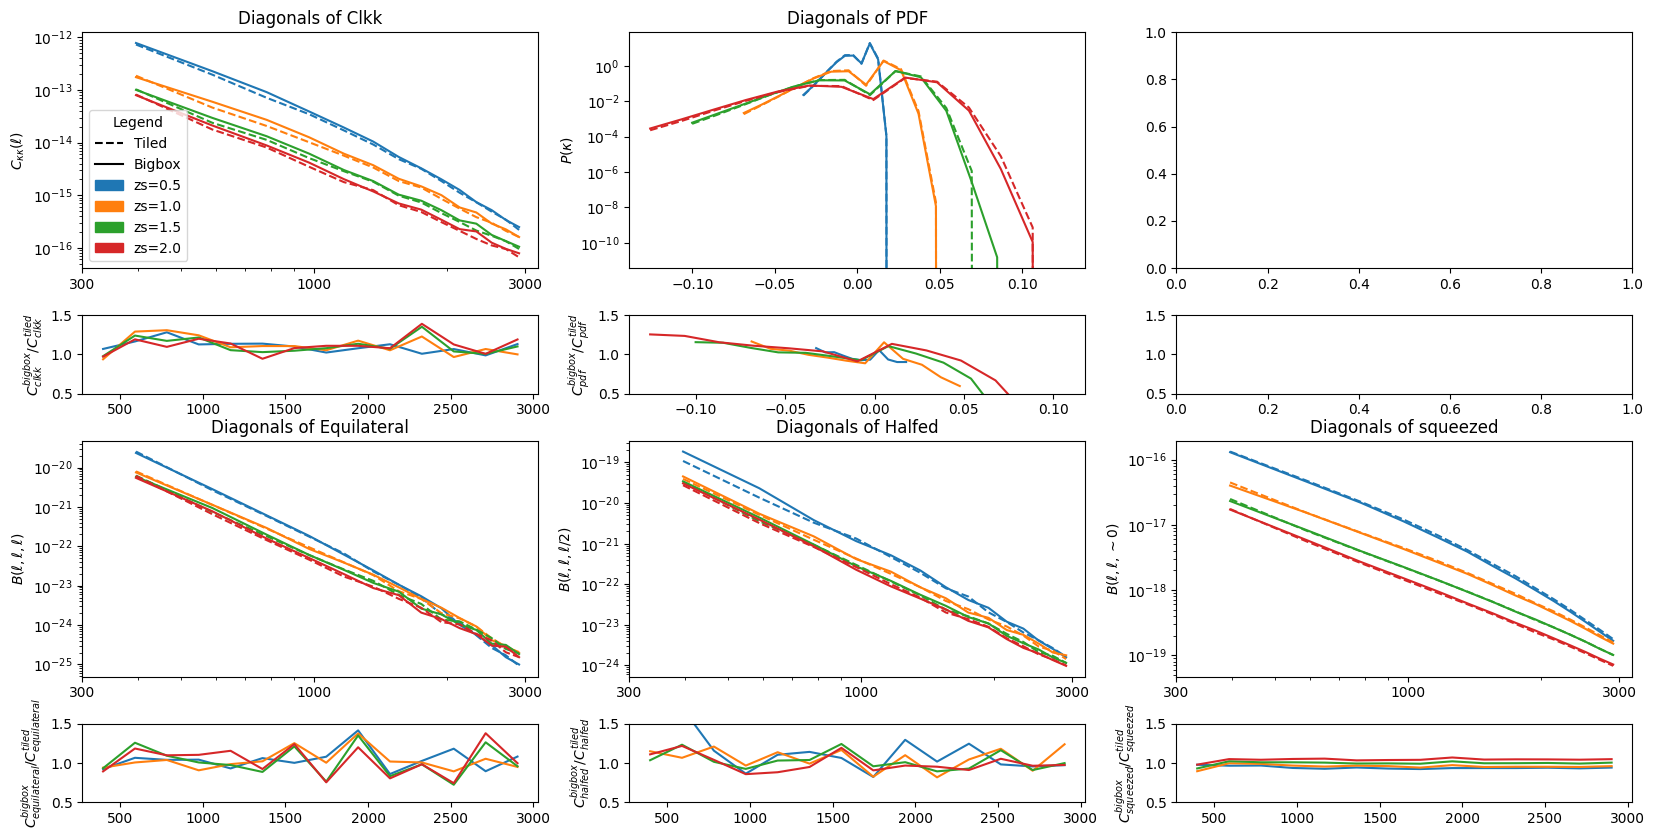

In [180]:
# Define colormap
cmap = plt.get_cmap("tab10")
colors = {zs: cmap(i) for i, zs in enumerate(zs_list)}

# Define line styles
line_styles = {"tiled": "--", "bigbox": "-"}

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(4, 3, height_ratios=[3, 1, 3, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)] + [fig.add_subplot(gs[2, i]) for i in range(3)]
ratio_axes = [fig.add_subplot(gs[1, i]) for i in range(3)] + [fig.add_subplot(gs[3, i]) for i in range(3)]

for i, zs in enumerate(zs_list):
    axes[0].plot(data_clkk_tiled[i][0], data_clkk_tiled[i][4], color=colors[zs], label=f"tiled", linestyle=line_styles["tiled"])
    axes[0].plot(data_clkk_bigbox[i][0], data_clkk_bigbox[i][4], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])

    axes[1].plot(data_pdf_tiled[i][0], data_pdf_tiled[i][4], color=colors[zs], label=f"tiled", linestyle=line_styles["tiled"])
    axes[1].plot(data_pdf_bigbox[i][0], data_pdf_bigbox[i][4], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])

    axes[3].plot(data_bispec_tiled_equilateral[i][0], data_bispec_tiled_equilateral[i][4], color=colors[zs], label=f"tiled", linestyle=line_styles["tiled"])
    axes[3].plot(data_bispec_bigbox_equilateral[i][0], data_bispec_bigbox_equilateral[i][4], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])

    axes[4].plot(data_bispec_tiled_halfed[i][0], data_bispec_tiled_halfed[i][4], color=colors[zs], label=f"tiled", linestyle=line_styles["tiled"])
    axes[4].plot(data_bispec_bigbox_halfed[i][0], data_bispec_bigbox_halfed[i][4], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])

    axes[5].plot(data_bispec_tiled_squeezed[i][0], data_bispec_tiled_squeezed[i][4], color=colors[zs], label=f"tiled", linestyle=line_styles["tiled"])
    axes[5].plot(data_bispec_bigbox_squeezed[i][0], data_bispec_bigbox_squeezed[i][4], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])

    # Plot the ratio 
    ratio_axes[0].plot(data_clkk_tiled[i][0], data_clkk_bigbox[i][4]/data_clkk_tiled[i][4], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])
    ratio_axes[1].plot(data_pdf_tiled[i][0], data_pdf_bigbox[i][4]/data_pdf_tiled[i][4], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])
    ratio_axes[3].plot(data_bispec_tiled_equilateral[i][0], data_bispec_bigbox_equilateral[i][4]/data_bispec_tiled_equilateral[i][4], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])
    ratio_axes[4].plot(data_bispec_tiled_halfed[i][0], data_bispec_bigbox_halfed[i][4]/data_bispec_tiled_halfed[i][4], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])
    ratio_axes[5].plot(data_bispec_tiled_squeezed[i][0], data_bispec_bigbox_squeezed[i][4]/data_bispec_tiled_squeezed[i][4], color=colors[zs], label=f"bigbox", linestyle=line_styles["bigbox"])

# Set the axis labels
axes[0].set_ylabel(r"$C_{\kappa\kappa}(\ell)$")
axes[1].set_ylabel(r"$P(\kappa)$")
axes[3].set_ylabel(r"$B(\ell, \ell, \ell)$")
axes[4].set_ylabel(r"$B(\ell, \ell, \ell/2)$")
axes[5].set_ylabel(r"$B(\ell, \ell, \sim 0)$")

ratio_axes[0].set_ylabel(r"$C_{clkk}^{bigbox}/C_{clkk}^{tiled}$")
ratio_axes[1].set_ylabel(r"$C_{pdf}^{bigbox}/C_{pdf}^{tiled}$")
ratio_axes[3].set_ylabel(r"$C_{equilateral}^{bigbox}/C_{equilateral}^{tiled}$")
ratio_axes[4].set_ylabel(r"$C_{halfed}^{bigbox}/C_{halfed}^{tiled}$")
ratio_axes[5].set_ylabel(r"$C_{squeezed}^{bigbox}/C_{squeezed}^{tiled}$")

# Set the axis ticks
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xticks([300, 1000, 3000])
axes[0].get_xaxis().set_major_formatter(plt.ScalarFormatter())
axes[0].get_xaxis().set_minor_formatter(plt.NullFormatter())

axes[1].set_yscale("log")
axes[1].get_xaxis().set_major_formatter(plt.ScalarFormatter())
axes[1].get_xaxis().set_minor_formatter(plt.NullFormatter())

for ax in axes[3:]:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticks([300, 1000, 3000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.get_xaxis().set_minor_formatter(plt.NullFormatter())

for ax in ratio_axes:
    ax.set_ylim(0.5, 1.5)

# Custom legend handles
legend_handles = []

# Add handles for line styles
legend_handles.append(Line2D([0], [0], color='black', linestyle=line_styles["tiled"], label='Tiled'))
legend_handles.append(Line2D([0], [0], color='black', linestyle=line_styles["bigbox"], label='Bigbox'))

# Add handles for colors (redshifts)
for zs in zs_list:
    legend_handles.append(Patch(color=colors[zs], label=f"zs={zs}"))

# Place the legend in the first subplot
axes[0].legend(handles=legend_handles, title="Legend", loc='lower left')

# Set the title
axes[0].set_title("Diagonals of Clkk")
axes[1].set_title("Diagonals of PDF")
axes[3].set_title("Diagonals of Equilateral")
axes[4].set_title("Diagonals of Halfed")
axes[5].set_title("Diagonals of squeezed")

# Save the figure
#plt.savefig(os.path.join(config_analysis.resultsdir, "correlation.pdf"), bbox_inches="tight")

plt.tight_layout()
plt.show()